# Import libraries

In [12]:
import pandas as pd
import numpy as np
import cv2
import os
import re

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

import matplotlib.pyplot as plt

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torch.utils.data import DataLoader, Dataset

from matplotlib import pyplot as plt

from xml.etree import ElementTree as et

# Util functions for calculate metrics

In [13]:
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1
    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1
        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

# Define dataset

In [14]:
# defining the files directory and testing directory
files_dir = 'data/trainval'
test_dir = 'data/test'


class MaizeTasselDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
        
        # classes: 0 index is reserved for background
        self.classes = [_, 'Maize']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])        
    
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        if len(boxes) !=0:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            area = torch.zeros((1,), dtype=torch.float32)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target, img_name

    def __len__(self):
        return len(self.imgs)

In [15]:
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.OneOf([
                                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                                     val_shift_limit=0.2, p=0.9),
                                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                                           contrast_limit=0.2, p=0.9),
                            ],p=0.9),
                            A.ToGray(p=0.01),
                            A.HorizontalFlip(p=0.5),
                            A.VerticalFlip(p=0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


# Load model

In [16]:
device = torch.device('cpu')

# Load your model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
model.load_state_dict(torch.load("fasterrcnn.pth", map_location=device))

<All keys matched successfully>

In [17]:
# Move the model to the appropriate device
model = model.to(device)

In [18]:
def collate_fn(batch):
    return tuple(zip(*batch))
test_data = MaizeTasselDataset(test_dir, 1024, 1024, get_transform(train=False))
test_data_loader = DataLoader(
    test_data,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

# Example image test

In [19]:
model.eval()
images, targets, image_ids = test_data[2]
images = images.unsqueeze(0)
images = images.to(device)
outputs = model(images)


detection_threshold = 0.6
prediction_boxes = outputs[0]['boxes'].data.cpu().numpy()
scores = outputs[0]['scores'].data.cpu().numpy()

prediction_boxes = prediction_boxes[scores >= detection_threshold].astype(np.int32)
expected_boxes = targets['boxes'].cpu().numpy().astype(np.int32)

In [20]:
def draw_boxes_on_image(boxes, images):
    sample = images[0].permute(1, 2, 0).cpu().numpy().copy()

    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.set_axis_off()
    ax.imshow(sample)
    print(f"Tassel count: {len(boxes)}")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EXPECTED OUTPUT

Tassel count: 11


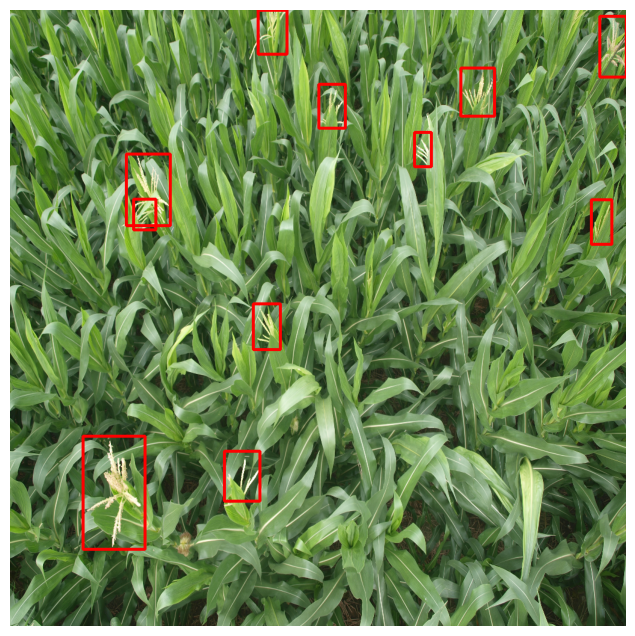

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PREDICTED OUTPUT

Tassel count: 12


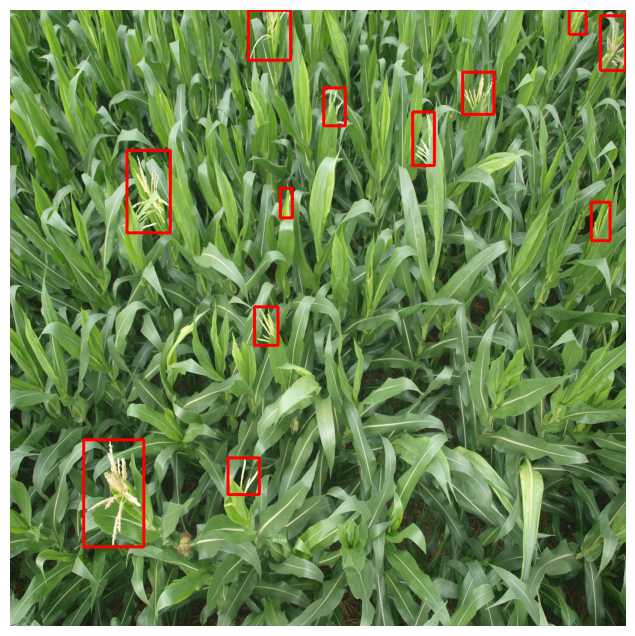

In [21]:
print("EXPECTED OUTPUT\n")
draw_boxes_on_image(expected_boxes, images)

print("PREDICTED OUTPUT\n")
draw_boxes_on_image(prediction_boxes, images)


# Evaluate

In [22]:
model.eval()
true_val = []
pred_val = []
iou_thresholds = [0.6]
for images, targets, image_ids in test_data_loader:       
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
    with torch.no_grad():
        outputs = model(images)
            
    
    for i, image in enumerate(images):
        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        gt_boxes = targets[i]['boxes'].cpu().numpy()
        prediction_boxes = boxes[scores >= iou_thresholds].astype(np.int32)
        true_val.append(len(gt_boxes))
        pred_val.append(len(prediction_boxes))


In [23]:
def calculate_mae(predicted_values, true_values):
    # Ensure the input lists have the same length
    assert len(predicted_values) == len(true_values), "Input lists must have the same length"

    # Calculate absolute differences for each example
    absolute_differences = [abs(true - pred) for pred, true in zip(predicted_values, true_values)]

    # Calculate the mean absolute error
    mae = sum(absolute_differences) / len(absolute_differences)

    return mae

In [24]:
def calculate_mse(predicted_values, true_values):
    # Ensure the input lists have the same length
    assert len(predicted_values) == len(true_values), "Input lists must have the same length"

    # Calculate squared differences for each example
    squared_differences = [(true - pred)**2 for pred, true in zip(predicted_values, true_values)]

    # Calculate the mean squared error
    mse = sum(squared_differences) / len(squared_differences)

    return mse ** 0.5

In [25]:
mae = calculate_mae(pred_val, true_val)

In [26]:
mse = calculate_mse(pred_val, true_val)

In [27]:
mae

4.8342857142857145

In [28]:
mse

8.48999411071645